# ECBM E4070 Project 1 [P-Ring Simulations]

    Name: Suheyla Tozan, Vanshika Sriram, Ivan Rivera
    Uni: stt2126, vs2668, ier2112

To run the code just restart the kernel and run all cells
* Note - the velocity vs unilateral input plot only shows the CCW simulation, but the graph is the same with CW as well

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import math

## Preliminary functions

In [2]:
def current(amplitude=.5): 
    
    position = 2
    X = np.zeros((2,8,100))
    ext_I = np.zeros((8,100))
    
    for i in range(100): #steps
        X[:,position,:] = amplitude
    for i in range(8): #wedges
        ext_I[i,:] = X[0,i,:] 
            
    return ext_I

ext_I = current()

def synaptic_I(n, beta): # n = firing rate value
    return n*beta

def ceiling(x): #x = value
    if x < 0:
        return 0
    elif 0 <= x < 1:
        return x
    else:
        return 1

def firing_rate(firing_prev, net_current, ring_sum=0, ntype="EIP"):
    summation = 0
    alpha = 0.1
    
    if ntype == "PEN": #blue
        summation = net_current
    elif ntype == "EIP": #green
        summation = net_current + ring_sum
    return ceiling(alpha*firing_prev + summation)

def ring_neuron(firing_at_step, beta_ringtog):
    width, neuron = firing_at_step.shape
    summation = 0
    alpha = 0.1
    
    for w in range(width):
        for n in range(neuron):
            if n == 1 or n == 3:
                summation += firing_at_step[w,n]
         
    return synaptic_I(summation, beta_ringtog)

## P Ring implementation

In [3]:
neuron_types = 4 #0 = top CCW PEN, #1 = left CCW EIP, #2 = bottom CW PEN, #3 = right CW EIP

beta_PENtoEIP = 4
beta_EIPtoPEN = 8
beta_ringtog = .05

def P_ring(CCW = True, ext_I = ext_I):
    firing = np.ones((100,8,neuron_types)) 
    I = np.zeros((100,8,neuron_types))
    
    for i in range(100): #for all time
        for j in range(8): #for all positions
            for k in range(4): #for neuron
                if CCW == True:
                    
                    if k == 0: #top CCW PEN
                        if i == 0: #if time = 0 then prev firing value = 0 and only ext I for PEN 
                            if j !=7: 
                                I[i,j,k] = synaptic_I(0,beta_PENtoEIP)+ ext_I[j,i]
                                firing[i,j,k] = firing_rate(0, I[i, j+1, 1], ntype="PEN")
                            elif j == 7: #when j = 7 it takes the value from j = 0 not j+1
                                I[i,j,k] = synaptic_I(0,beta_PENtoEIP)+ ext_I[j,i]
                                firing[i,j,k] = firing_rate(0, I[i, 0, 1], ntype="PEN")   

                        elif i != 0: #takes value from t-1, wedge prior (j+1 for CCW) and firing output from left EIP
                            if j !=7: 
                                I[i,j,k] = synaptic_I(firing[i-1,j+1,1],beta_PENtoEIP)+ ext_I[j,i]
                                firing[i,j,k] = firing_rate(firing[i-1,j+1,1], I[i, j+1, 1], ntype="PEN")

                            elif j == 7: #when j = 7 it takes the value from j = 0 not j+1
                                I[i,j,k] = synaptic_I(firing[i-1,0,1],beta_PENtoEIP)+ ext_I[j,i]
                                firing[i,j,k] = firing_rate(firing[i-1,0,1], I[i, 0, 1], ntype="PEN")                        

                    elif k == 1: #left CCW EIP
                        if i == 0: #if time = 0 then prev firing value = 0 and I only consists of synaptic I
                            I[i,j,k] = synaptic_I(0,beta_EIPtoPEN)
                            firing[i,j,k] = firing_rate(0, I[i,j,0], ntype="EIP")
                            I[i,j,3] = I[i,j,k]
                            firing[i,j,3] = firing[i,j,k]

                        elif i!=0: #takes value from CCW PEN from same wedge from time before
                            ring_sum = ring_neuron(firing[i,:,:], -beta_ringtog)
                            I[i,j,k] = synaptic_I(firing[i-1,j,0],beta_EIPtoPEN) + ring_sum
                            firing[i,j,k] = firing_rate(firing[i-1,j,0], I[i,j,0], ring_sum, ntype="EIP")
                            I[i,j,3] = I[i,j,k]
                            firing[i,j,3] = firing[i,j,k]

                    elif k ==2: #CW PEN - is off
                        firing[i,j,k] = 0 
                        I[i,j,k] = 0
                        
                if CCW == False:
                    
                    if k == 0: #top CCW PEN - negative betas to keep cell off
                        firing[i,j,k] = 0 
                        I[i,j,k] = 0

                    elif k ==2: #CW PEN
                        if i == 0: #if time is 0 then prev firing rate value = 0 and it takes in only ext_I
                            if j == 0:
                                I[i,j,k] = synaptic_I(0,beta_PENtoEIP)+ ext_I[j,i]
                                firing[i,j,k] = firing_rate(0, I[i,7,3], ntype="PEN") 

                            elif j !=0:
                                I[i,j,k] = synaptic_I(0,beta_PENtoEIP)+ ext_I[j,i]
                                firing[i,j,k] = firing_rate(0, I[i,j-1,3], ntype="PEN")       

                        elif i !=0: #if time>0 then firing takes value from prev time, and CW EIP from prev wedge
                            if j == 0: #if j ==0 then it takes value from j = 7 CW EIP 
                                I[i,j,k] = synaptic_I(firing[i-1,7,3],beta_PENtoEIP)+ ext_I[j,i]
                                firing[i,j,k] = firing_rate(firing[i-1,7,3], I[i,7,3], ntype="PEN") 

                            elif j !=0:
                                I[i,j,k] = synaptic_I(firing[i-1,j-1,3],beta_PENtoEIP)+ ext_I[j,i]  
                                firing[i,j,k] = firing_rate(firing[i-1,j-1,3], I[i,j-1,3], ntype="PEN")

                    elif k == 3: #top CCW EIP - takes in value from CW PEN but outputs to nothing
                        if i == 0: #if time is 0 then prev firing rate value = 0 and I is only synaptic I
                            I[i,j,k] = synaptic_I(0,beta_EIPtoPEN)
                            firing[i,j,k] = firing_rate(0, I[i,j,2], ntype="EIP")
                            I[i,j,1] = I[i,j,k]
                            firing[i,j,1] = firing[i,j,k]

                        elif i!=0: #if t>0 then prev firing rate is of same wedge but CW PEN
                            ring_sum = ring_neuron(firing[i,:,:], -beta_ringtog)
                            I[i,j,k] = synaptic_I(firing[i-1,j,2],beta_EIPtoPEN) + ring_sum
                            firing[i,j,k] = firing_rate(firing[i-1,j,2], I[i,j,2], ring_sum, ntype="EIP")
                            I[i,j,1] = I[i,j,k]
                            firing[i,j,1] = firing[i,j,k]

    return firing

In [4]:
simCW = P_ring(CCW = False)
simCCW = P_ring(CCW = True)

## Subplots of CCW and CW simulation
Firing rate against time for each wedge and each neuron type

Provided for suppplemental information. See Heatmaps for final output.

In [5]:
def make_subplot(a): #a = simCCW or CW
    
    time = np.arange(0,100,1)
    fig, axs = plt.subplots(4, 8,figsize=(25,15), sharey = True)
    fig.tight_layout(pad=2.5)
    
    for i in range(8):
        axs[0,i].set_title("wedge {}".format(i))
        
        for j in range(4):
            axs[j,i].plot(time, a[:,i,j])
    
    axs[0,0].set_ylabel("CCW PEN")
    axs[1,0].set_ylabel("CCW EIP")
    axs[2,0].set_ylabel("CW PEN")
    axs[3,0].set_ylabel("CW EIP")
    return plt.show()

COUNTERCLOCKWISE OUTPUT

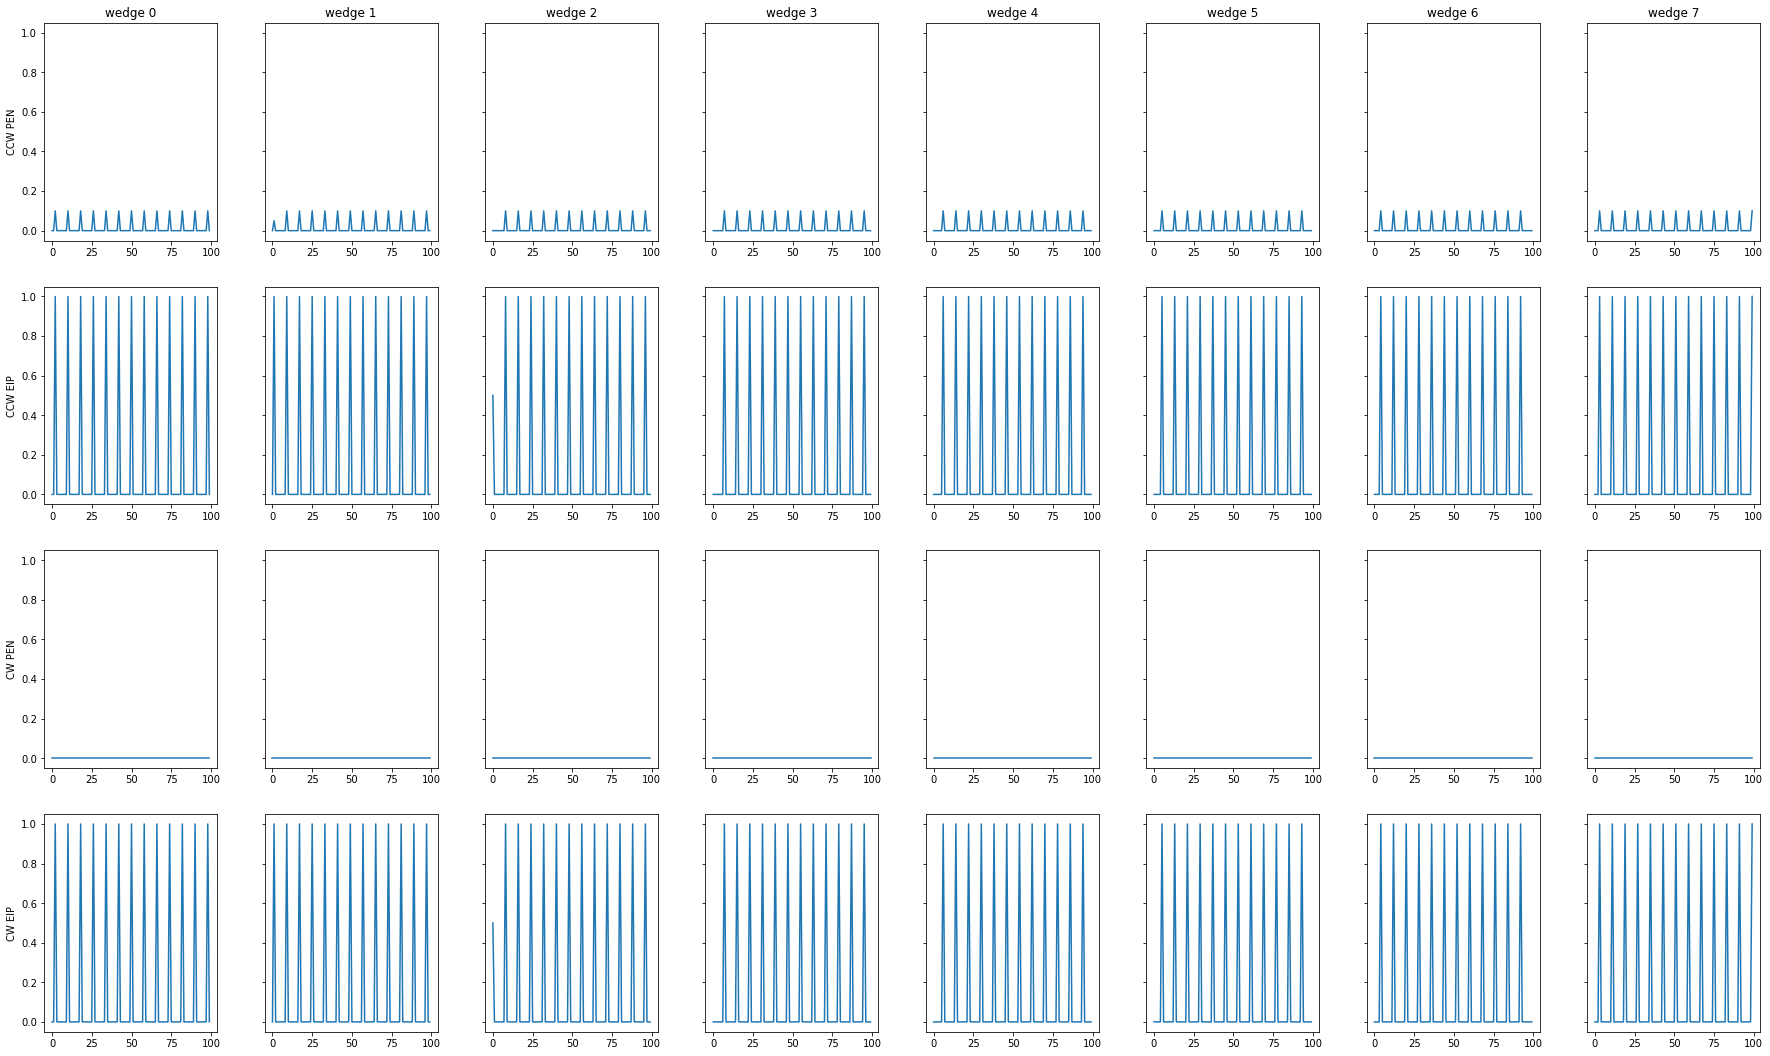

In [6]:
make_subplot(simCCW)

CLOCKWISE OUTPUT

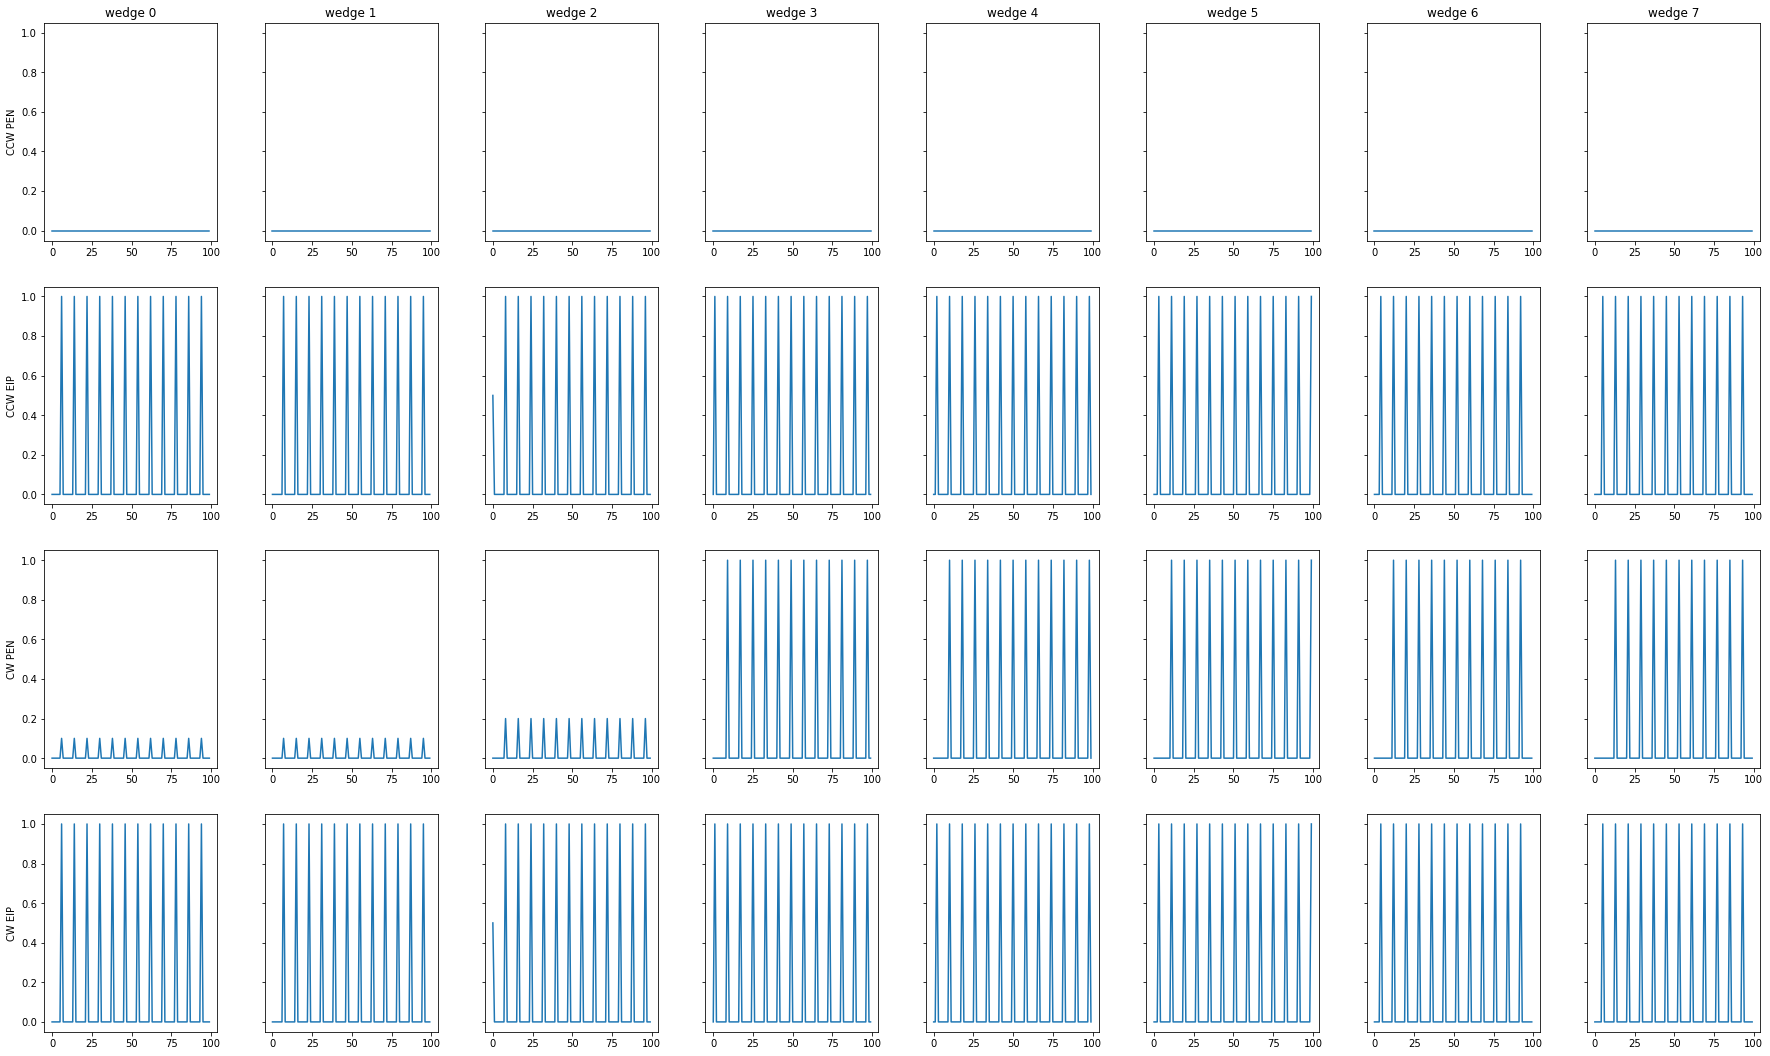

In [7]:
make_subplot(simCW)

## Heatgraphs
For each neuron type showing same data as above

In [8]:
def heatgraph(a): #a = simCW or simCCW
    output_neurons = [0,0,0,0]

    firing_red_1 = a[:,:,0]
    firing_red_2 = a[:,:,1]
    firing_green_1 = a[:,:,2]
    firing_green_2 = a[:,:,3]

    rows = 1
    columns = 4
    fig, axes = plt.subplots(rows, columns, figsize=(20,12), constrained_layout = True)
    ax1, ax2, ax3, ax4 = axes
    im1 = ax1.imshow(firing_red_1, aspect=1/10)
    ax1.set_title('CCW PEN')
    fig.colorbar(im1,ax=ax1,fraction=0.050, pad=0.02)
    im2 = ax2.imshow(firing_red_2, aspect=1/10)
    ax2.set_title('CCW EIP')
    fig.colorbar(im2,ax=ax2,fraction=0.050, pad=0.02)
    im3 = ax3.imshow(firing_green_1, aspect=1/10)
    ax3.set_title('CW PEN')
    fig.colorbar(im3,ax=ax3,fraction=0.050, pad=0.02)
    im4 = ax4.imshow(firing_green_2, aspect=1/10)
    ax4.set_title('CW EIP')
    fig.colorbar(im4,ax=ax4,fraction=0.050, pad=0.02)

    return plt.show()

COUNTERCLOCKWISE OUTPUT

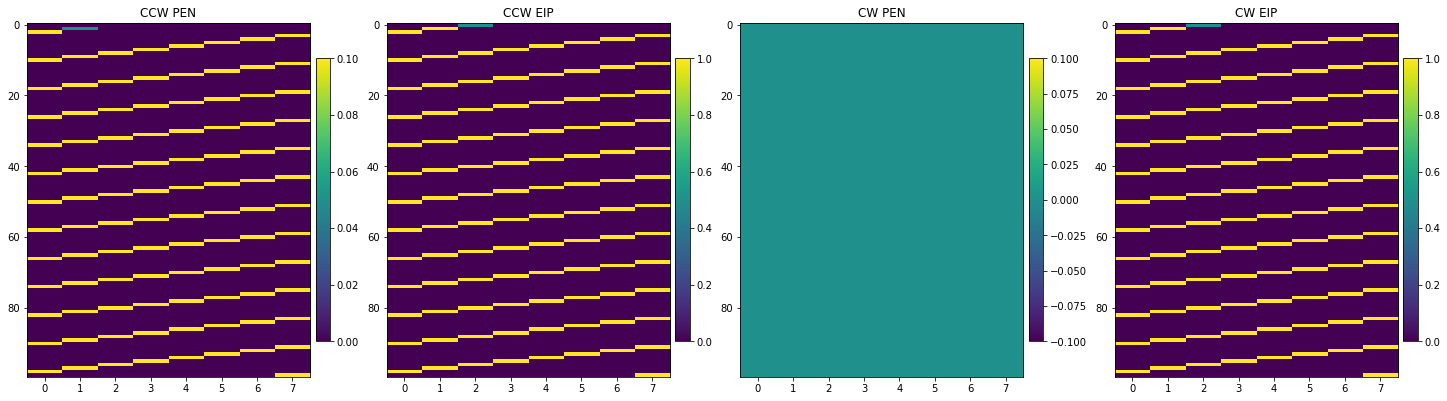

In [9]:
heatgraph(simCCW)

CLOCKWISE OUTPUT

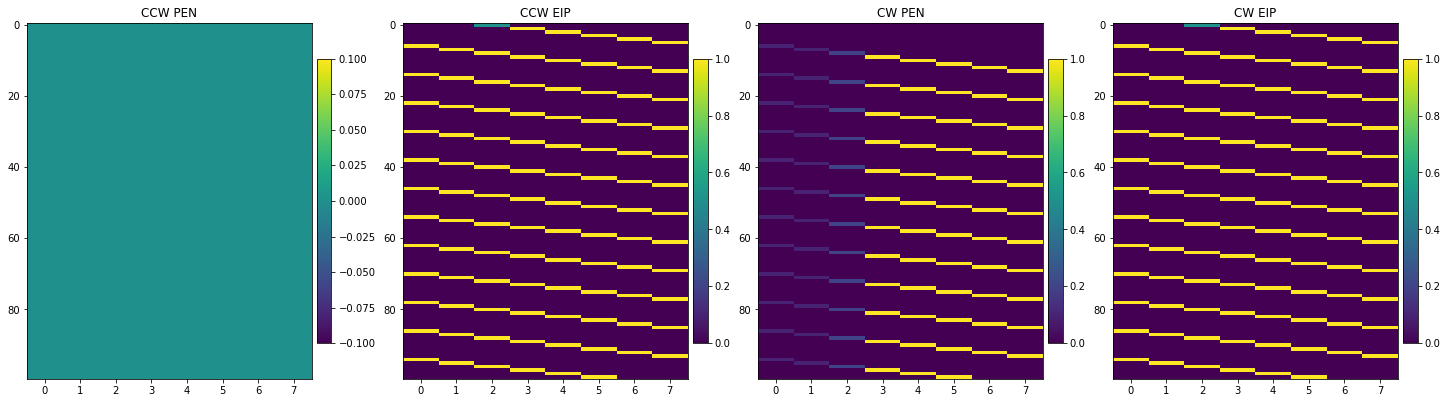

In [10]:
heatgraph(simCW)

## Velocity vs input current graphs

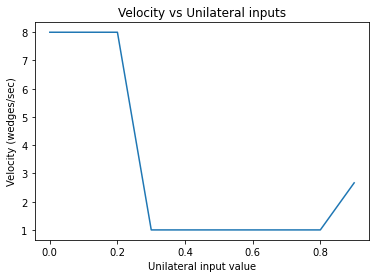

In [11]:
#velocity plot
def velocity(a): #a = simCCW or simCW
    """
    - using the CCW EIP, wedge 0 as a basis
    - this function finds the peaks and the time interval between them
        - this sees how long a bump takes to make a full rotation
    - then calculates the velocity by 8/T
        -  T = interval, 8 = number of wedges it passes through in a full rotation
    - velocity = wedges per second
    """
    
    peak_times = []
    a_flat = a[:,0,1]
    peak = np.amax(a_flat)
    
    for i in range(100):
        if a[i,0,1] == peak:
            peak_times.append(i)
        else:
            continue
            
    T = peak_times[2]- peak_times[1] #time interval - is equal between all peaks
    v = 8/T
    
    return v

def velocity_plot():
    
    unilateral_inputs = np.arange(0,1, .1)
    velocities = np.zeros_like(unilateral_inputs)
    
    for i in range(len(unilateral_inputs)):
        
        I = current(amplitude=unilateral_inputs[i])
        sim = P_ring(CCW = True, ext_I = I)
        velocities[i] = velocity(sim)
    
    plt.plot(unilateral_inputs, velocities)
    plt.xlabel("Unilateral input value")
    plt.ylabel("Velocity (wedges/sec)")
    plt.title("Velocity vs Unilateral inputs")
    return plt.show()

velocity_plot() #only shown for CCW direction, but velocities are same for CW